In [1]:
import sys 
sys.path.append(rf"/nfs/home/genovese/thesis-wildfire-genovese/src")
from importlib import reload
import utils
reload(utils)
from utils import *
data_folder = "/nfs/home/genovese/thesis-wildfire-genovese/data/"

In [ ]:
from shapely import wkt

for a in list(range(2000, 2025)):
    df = pd.read_csv(f'/nfs/home/genovese/thesis-wildfire-genovese/data/clean_data/weather_forecast/{a}.csv')
    df['geometry'] = wkt.loads(df['geometry'])
    gdf = gpd.GeoDataFrame(df, geometry='geometry')
    save_clean_data(gdf,
                    str(a),
                    f'/nfs/home/genovese/thesis-wildfire-genovese/data/gathering_geojson/weather_forecast')

In [37]:
from sklearn.preprocessing import OneHotEncoder

gdf = gpd.read_file('/nfs/home/genovese/thesis-wildfire-genovese/data/gathering_geojson/vegetazione.geojson')

encoder = OneHotEncoder()  # define order
encoded = encoder.fit_transform(gdf[['CATEGORIA']]).toarray()


In [40]:
pd.DataFrame(encoded).describe()

,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
count,128693.000000,128693.000000,128693.000000,128693.000000,128693.000000,128693.000000,128693.000000,128693.000000,128693.000000,128693.000000,...,128693.000000,128693.000000,128693.000000,128693.000000,128693.000000,128693.000000,128693.000000,128693.000000,128693.000000,128693.000000
mean,0.005066,0.047819,0.008983,0.012534,0.021081,0.071239,0.088886,0.003691,0.046009,0.034835,...,0.003776,0.000435,0.001811,0.009239,0.019426,0.039140,0.046009,0.026839,0.178324,0.031867
std,0.070998,0.213384,0.094350,0.111251,0.143656,0.257225,0.284580,0.060641,0.209505,0.183362,...,0.061337,0.020856,0.042512,0.095675,0.138018,0.193928,0.209505,0.161614,0.382786,0.175645
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [25]:
import rasterio
from rasterio.features import rasterize
from rasterio.transform import from_origin


def rasterise_shp(shapefile_path, output_raster, resolution = 100, attributes = None):

    # === Load shapefile ===
    gdf = gpd.read_file(shapefile_path)
    bounds = gdf.total_bounds  # (minx, miny, maxx, maxy)

    # === Define raster resolution and size ===
    minx, miny, maxx, maxy = bounds
    width = int((maxx - minx) / resolution)
    height = int((maxy - miny) / resolution)
    transform = from_origin(minx, maxy, resolution, resolution)

    # attributes = list(gdf.columns)
    # attributes.remove('geometry')
    # === Convert geometries and optional values ===
    for att in attributes:
        if att:
            shapes = ((geom, value) for geom, value in zip(gdf.geometry, gdf[att]))
        else:
            shapes = ((geom, 1) for geom in gdf.geometry)

        raster = rasterize(
            shapes=shapes,
            out_shape=(height, width),
            transform=transform,
            fill=-1000,
            # dtype='float32'
        )
    
        # === Save raster to file ===
        with rasterio.open(
            output_raster,
            'w',
            driver='GTiff',
            height=height,
            width=width,
            count=1,
            dtype=raster.dtype,
            crs=gdf.crs,
            transform=transform,
        ) as dst:
            dst.write(raster, 1)

    print(f"Raster saved to {output_raster}")


In [28]:
rasterise_shp('/nfs/home/genovese/thesis-wildfire-genovese/data/gathering_geojson/vegetazione.geojson', 
              '/nfs/home/genovese/thesis-wildfire-genovese/outputs/rasterisations/vegetazione.tif',
              attributes=['ESTENSIONE'])

Raster saved to /nfs/home/genovese/thesis-wildfire-genovese/outputs/rasterisations/vegetazione.tif


Number of channels: 1


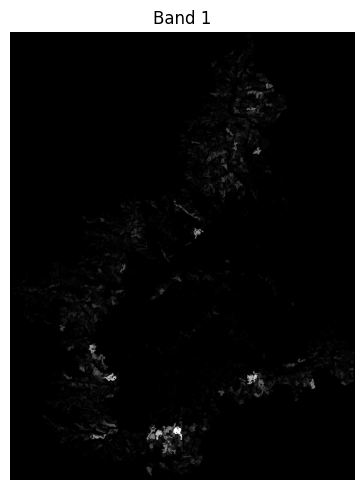

In [ ]:
# Open the TIFF file
with rasterio.open("/nfs/home/genovese/thesis-wildfire-genovese/outputs/rasterisations/vegetazione.tif") as src:
    num_channels = src.count
    print(f"Number of channels: {num_channels}")

    # Read and plot each channel
    fig, axs = plt.subplots(1, num_channels, figsize=(5 * num_channels, 5))
    if num_channels == 1:
        axs = [axs]  # Ensure it's iterable

    for i in range(1, num_channels + 1):
        band = src.read(i)
        axs[i-1].imshow(band, cmap='gray')
        axs[i-1].set_title(f'Band {i}')
        axs[i-1].axis('off')

    plt.tight_layout()
    plt.show()